In [1]:
import polars as pl
import numpy as np

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import sklearn.model_selection as ms
from sklearn.linear_model import SGDClassifier

from tensorflow.keras.preprocessing.image import ImageDataGenerator

import sys
sys.path.append("/Users/leon/Desktop/kaggle/")
from src.plotting import MetricPlots as mp
import matplotlib.pyplot as plt

In [2]:
df = pl.read_csv("./data/train.csv")
data = df.to_numpy()
X, y = data[:, 1:], data[:, 0]

In [ ]:
sss = ms.StratifiedShuffleSplit(n_splits=5, test_size=0.1, random_state=42)
scores = []
for train_index, test_index in sss.split(X, y):
	X_train, X_test = X[train_index], X[test_index]
	y_train, y_test = y[train_index], y[test_index]

	sgd_clf = SGDClassifier().fit(X_train, y_train)
	scores.append(sgd_clf.score(X_test, y_test))

np.array(scores).mean()

# Initial Predictions using SGDClassifier

In [ ]:
X_train, X_test, y_train, y_test = ms.train_test_split(X, y, test_size=0.1, random_state=42)
sgd_clf = SGDClassifier().fit(X_train, y_train)
sgd_clf.score(X_test, y_test)

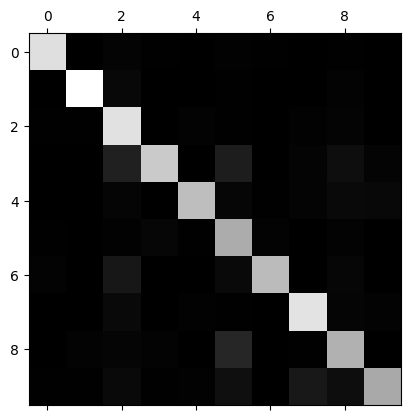

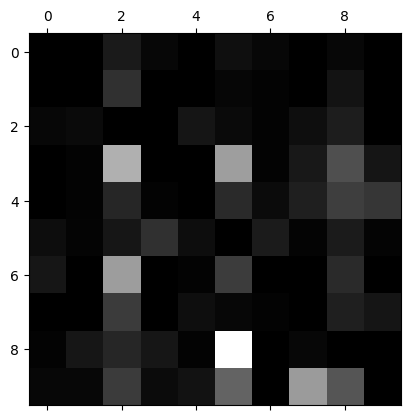

In [47]:
y_pred = sgd_clf.predict(X_test)
mp.gen_and_plot_conf_mx(y_test, y_pred)
mp.gen_and_plot_error_conf_mx(y_test, y_pred)

# **More samples for incorrect classes**
## **Big Errors**
- true 2 interpreted as 8
- true 5 interpreted as 8
## **Smaller Errors**
- true 5 interpreted as 3
- true 8 interpreted as 3


In [3]:
import math
s = int(math.sqrt(784))
data_2 = df.filter(pl.col("label") == 2).drop("label").to_numpy().reshape(-1, s, s)
data_3 = df.filter(pl.col("label") == 3).drop("label").to_numpy().reshape(-1, s, s)
data_5 = df.filter(pl.col("label") == 5).drop("label").to_numpy().reshape(-1, s, s)
data_7 = df.filter(pl.col("label") == 7).drop("label").to_numpy().reshape(-1, s, s)
data_8 = df.filter(pl.col("label") == 8).drop("label").to_numpy().reshape(-1, s, s)
data_2.shape

(4177, 28, 28)

In [15]:
gen = ImageDataGenerator(
	rotation_range=2,
	width_shift_range=0.05,
	height_shift_range=0.05,
	shear_range=0.025,
	zoom_range=0.05,
	horizontal_flip=False,
	fill_mode="nearest"
)

In [16]:
imgs_2 = next(gen.flow(np.expand_dims(data_2, axis=-1), batch_size=2000)).reshape(-1, 784)
imgs_3 = next(gen.flow(np.expand_dims(data_3, axis=-1), batch_size=2000)).reshape(-1, 784)
imgs_5 = next(gen.flow(np.expand_dims(data_5, axis=-1), batch_size=2000)).reshape(-1, 784)
imgs_7 = next(gen.flow(np.expand_dims(data_7, axis=-1), batch_size=2000)).reshape(-1, 784)
imgs_8 = next(gen.flow(np.expand_dims(data_8, axis=-1), batch_size=2000)).reshape(-1, 784)
imgs_2.shape

(2000, 784)

In [27]:
X_new = np.vstack(
	[
		X,
		# imgs_2,
		imgs_3,
		# imgs_5,
		# imgs_7,
		imgs_8
	]
)
y_new = np.hstack(
	[
		y,
		# np.full((2000, ), 2),
		np.full((2000, ), 3),
		# np.full((2000, ), 5),
		# np.full((2000, ), 7),
		np.full((2000, ), 8)
	]
)

# SGDClassifier with new Data

In [28]:
sss = ms.StratifiedShuffleSplit(n_splits=1, test_size=0.1, random_state=42)
scores = []
for train_index, test_index in sss.split(X_new, y_new):
	X_train, X_test = X_new[train_index], X_new[test_index]
	y_train, y_test = y_new[train_index], y_new[test_index]

	sgd_clf = SGDClassifier().fit(X_train, y_train)
	scores.append(sgd_clf.score(X_test, y_test))

np.array(scores).mean()

0.8686956521739131

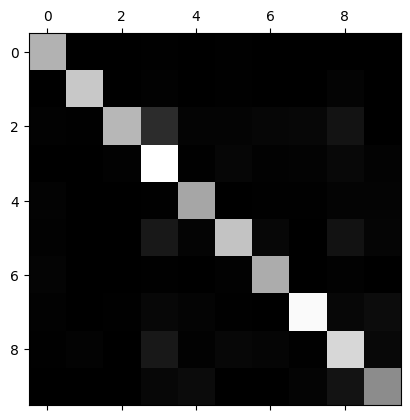

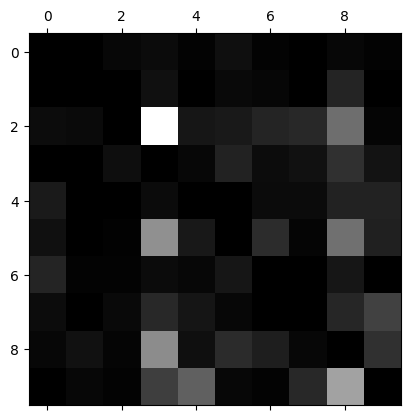

In [23]:
y_pred = sgd_clf.predict(X_test)
mp.gen_and_plot_conf_mx(y_test, y_pred)
mp.gen_and_plot_error_conf_mx(y_test, y_pred)

# RandomForestClassifier

In [29]:
from sklearn.ensemble import RandomForestClassifier
scores = []
for train_index, test_index in sss.split(X_new, y_new):
	X_train, X_test = X_new[train_index], X_new[test_index]
	y_train, y_test = y_new[train_index], y_new[test_index]

	sgd_clf = RandomForestClassifier().fit(X_train, y_train)
	scores.append(sgd_clf.score(X_test, y_test))

np.array(scores).mean()

0.9665217391304348

In [35]:
from sklearn.model_selection import GridSearchCV
rf_clf = RandomForestClassifier()
params = [
	# {"n_estimators": [10, 50, 100], "max_features": [10, 50, 100]}
	{"n_estimators": [70, 85, 100], "max_features": [100]}
]

for train_index, test_index in sss.split(X_new, y_new):
	X_train, X_test = X_new[train_index], X_new[test_index]
	y_train, y_test = y_new[train_index], y_new[test_index]

	res = GridSearchCV(
		estimator=rf_clf,
		param_grid=params,
		cv=5,
		scoring="accuracy"
	).fit(X_train, y_train)

	print(f"{res.best_params_}: {res}")

res.best_params_, res.score

{'max_features': 100, 'n_estimators': 100}: GridSearchCV(cv=5, estimator=RandomForestClassifier(),
             param_grid=[{'max_features': [100],
                          'n_estimators': [70, 85, 100]}],
             scoring='accuracy')


({'max_features': 100, 'n_estimators': 100},
 <bound method BaseSearchCV.score of GridSearchCV(cv=5, estimator=RandomForestClassifier(),
              param_grid=[{'max_features': [100],
                           'n_estimators': [70, 85, 100]}],
              scoring='accuracy')>)

In [37]:
print(f"{res.best_params_}: {res.score(X_test, y_test)}")


{'max_features': 100, 'n_estimators': 100}: 0.9706521739130435


In [33]:
res.best_estimator_.score(X_test, y_test)

0.9660869565217391

{'max_features': 100, 'n_estimators': ?}:0.9684782608695652
{'max_features': 100, 'n_estimators': 70}: 0.9660869565217391


In [ ]:
with open(file="./submission.csv", mode="w") as f:
	f.write("PassengerId,Survived\n")
	for k in solutions.keys():
		f.write(f"{k},{int(solutions[k][0])}\n")